In [268]:
import gymnasium as gym
import math
import random
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from gymnasium.wrappers import RecordVideo
import os
from IPython.display import HTML, display, clear_output
from base64 import b64encode
from google.colab import drive
from tqdm import tqdm
import numpy as np

In [269]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [270]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
env = gym.make("CartPole-v1", render_mode="rgb_array")

In [271]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

In [272]:
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [273]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [274]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 300
TAU = 0.01
LR = 1e-4

In [275]:
n_actions = env.action_space.n
state, _ = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=LR)
memory = ReplayMemory(10000)
steps_done = 0

In [276]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

In [277]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return

    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    state_action_values = policy_net(state_batch).gather(1, action_batch)
    next_state_values = torch.zeros(BATCH_SIZE, device=device)

    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values

    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()


episode_durations = []

In [278]:
def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)

    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')

    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())

    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)

In [279]:
TOTAL_EPISODES = 1000

In [280]:
def train_colab():
    video_env = RecordVideo(env, "video", episode_trigger=lambda x: x in [0, TOTAL_EPISODES-1])

    progress_bar = tqdm(total=TOTAL_EPISODES, desc="Training", unit="episode")


    metrics = {
        'durations': [],
        'epsilons': [],
        'losses': []
    }

    for episode in range(TOTAL_EPISODES):
        state, _ = video_env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
        episode_loss = []

        for t in count():
            action = select_action(state)
            observation, reward, terminated, truncated, info = video_env.step(action.item())
            reward = torch.tensor([reward], device=device) * 0.01
            done = terminated or truncated

            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0) if not done else None
            memory.push(state, action, next_state, reward)
            state = next_state if not done else None


            loss = optimize_model()
            if loss is not None:
                episode_loss.append(loss.item())


            target_net_state_dict = target_net.state_dict()
            policy_net_state_dict = policy_net.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
            target_net.load_state_dict(target_net_state_dict)

            if done:
                duration = t + 1
                metrics['durations'].append(duration)
                avg_loss = np.mean(episode_loss) if episode_loss else 0
                metrics['losses'].append(avg_loss)


                epsilon = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
                metrics['epsilons'].append(epsilon)


                progress_bar.set_postfix({
                    'duration': duration,
                    'avg': np.mean(metrics['durations'][-10:]),
                    'epsilon': f"{epsilon:.2f}",
                    'loss': f"{avg_loss:.4f}"
                })
                progress_bar.update(1)


                if episode % 10 == 0:
                    clear_output(wait=True)
                    plt.figure(figsize=(12, 4))


                    plt.subplot(1, 3, 1)
                    plt.title('Training Durations')
                    plt.plot(metrics['durations'])
                    plt.xlabel('Episode')
                    plt.ylabel('Duration')


                    plt.subplot(1, 3, 2)
                    plt.title('Training Loss')
                    plt.plot(metrics['losses'])
                    plt.xlabel('Episode')
                    plt.ylabel('Loss')


                    plt.subplot(1, 3, 3)
                    plt.title('Epsilon Decay')
                    plt.plot(metrics['epsilons'])
                    plt.xlabel('Step')
                    plt.ylabel('Epsilon')

                    plt.tight_layout()
                    plt.show()
                break

    progress_bar.close()
    video_env.close()


    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(metrics['durations'])
    plt.title('Episode Durations')
    plt.xlabel('Episode')
    plt.ylabel('Duration')

    plt.subplot(1, 3, 2)
    plt.plot(metrics['losses'])
    plt.title('Training Loss')
    plt.xlabel('Episode')
    plt.ylabel('Loss')

    plt.subplot(1, 3, 3)
    plt.plot(metrics['epsilons'])
    plt.title('Epsilon Decay')
    plt.xlabel('Step')
    plt.ylabel('Epsilon')

    plt.tight_layout()
    plt.show()

    torch.save(policy_net.state_dict(), '/content/drive/MyDrive/cartpole_model.pth')
    print(f"\n✅ Training completed! Model saved to Google Drive")

    return policy_net

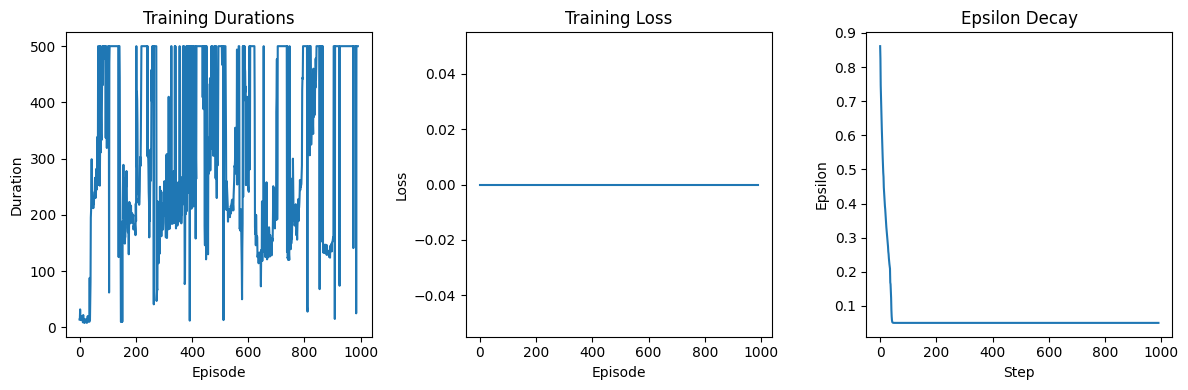



Training:  99%|█████████▉| 991/1000 [19:39<00:15,  1.74s/episode, duration=500, avg=452, epsilon=0.05, loss=0.0000]

Training:  99%|█████████▉| 992/1000 [19:39<00:14,  1.86s/episode, duration=500, avg=452, epsilon=0.05, loss=0.0000]

Training:  99%|█████████▉| 992/1000 [19:41<00:14,  1.86s/episode, duration=500, avg=452, epsilon=0.05, loss=0.0000]

Training:  99%|█████████▉| 993/1000 [19:41<00:12,  1.84s/episode, duration=500, avg=452, epsilon=0.05, loss=0.0000]

Training:  99%|█████████▉| 993/1000 [19:43<00:12,  1.84s/episode, duration=500, avg=452, epsilon=0.05, loss=0.0000]

Training:  99%|█████████▉| 994/1000 [19:43<00:10,  1.82s/episode, duration=500, avg=452, epsilon=0.05, loss=0.0000]

Training:  99%|█████████▉| 994/1000 [19:44<00:10,  1.82s/episode, duration=500, avg=500, epsilon=0.05, loss=0.0000]

Training: 100%|█████████▉| 995/1000 [19:44<00:09,  1.80s/episode, duration=500, avg=500, epsilon=0.05, loss=0.0000]

Training: 100%|█████████▉| 995/1000 [19:46<00:09,  1.80s/episo

Moviepy - Building video /content/video/rl-video-episode-999.mp4.
Moviepy - Writing video /content/video/rl-video-episode-999.mp4








Training:   0%|          | 0/1000 [20:33<?, ?episode/s]




Training:   0%|          | 0/1000 [20:33<?, ?episode/s]

Training: 100%|█████████▉| 999/1000 [19:51<00:00,  1.23episode/s, duration=500, avg=373, epsilon=0.05, loss=0.0000]

Training: 100%|██████████| 1000/1000 [19:51<00:00,  1.19s/episode, duration=500, avg=373, epsilon=0.05, loss=0.0000]


Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-999.mp4


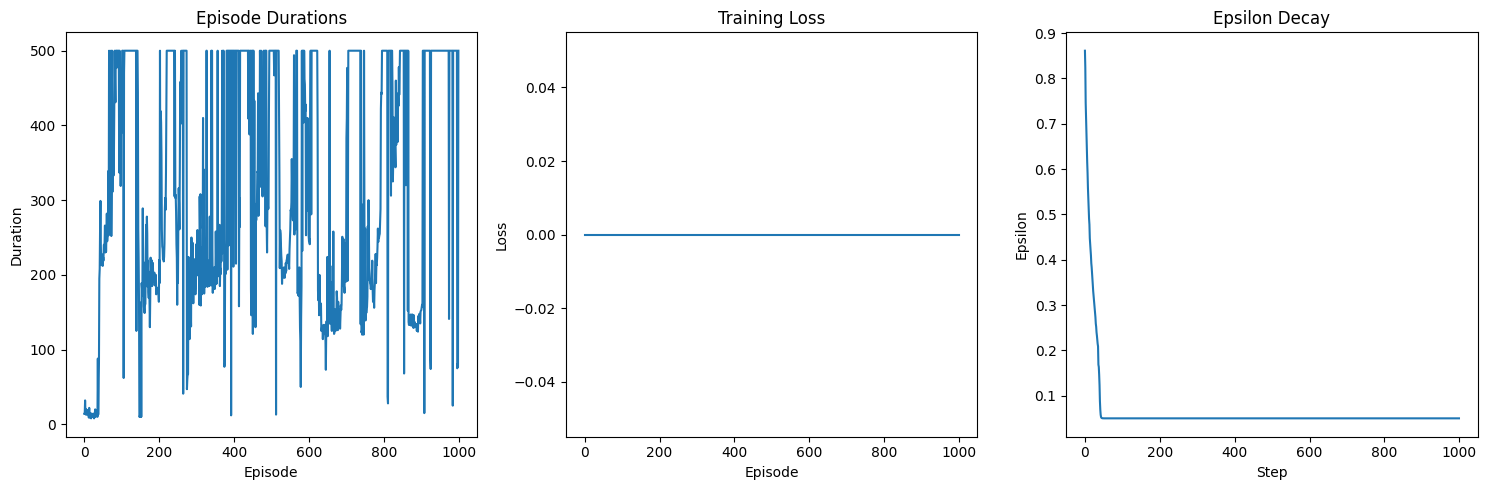


✅ Training completed! Model saved to Google Drive


In [281]:
trained_model = train_colab()

In [284]:
policy_net.load_state_dict(torch.load('/content/drive/MyDrive/cartpole_model.pth'))
policy_net.eval()

DQN(
  (layer1): Linear(in_features=4, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=64, bias=True)
  (layer3): Linear(in_features=64, out_features=2, bias=True)
)

In [287]:
env = gym.make('CartPole-v1', render_mode='rgb_array')

In [288]:
video_env = RecordVideo(env, "video", episode_trigger=lambda x: x in [0])


def validate_model():
    state, _ = video_env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    done = False
    while not done:
        action = select_action(state)
        observation, reward, terminated, truncated, info = video_env.step(action.item())
        state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        done = terminated or truncated

    video_env.close()

validate_model()



Training:   0%|          | 0/1000 [23:58<?, ?episode/s]

Training:   0%|          | 0/1000 [23:58<?, ?episode/s]

Moviepy - Building video /content/video/rl-video-episode-0.mp4.
Moviepy - Writing video /content/video/rl-video-episode-0.mp4





Training:   0%|          | 0/1000 [23:58<?, ?episode/s]

Training:   0%|          | 0/1000 [23:58<?, ?episode/s]

Moviepy - Done !
Moviepy - video ready /content/video/rl-video-episode-0.mp4


In [289]:
def show_video():
    video_path = "/content/video/rl-video-episode-0.mp4"


    if os.path.exists(video_path):
        try:

            with open(video_path, 'rb') as video_file:
                mp4 = video_file.read()


            data_url = "data:video/mp4;base64," + b64encode(mp4).decode()


            return HTML(f"""
                <video width=400 controls>
                    <source src="{data_url}" type="video/mp4">
                </video>
            """)
        except Exception as e:
            print(f"비디오 파일 처리 중 오류 발생: {e}")
    else:
        print("비디오 파일을 찾을 수 없습니다.")

In [290]:
show_video()